In [27]:
import os
import zipfile
import tensorflow as tf
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model

In [28]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')


In [29]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [4]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [5]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [6]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [7]:
# Set up matplotlib fig, and size it to fit 4x4 pics
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )


next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

<Figure size 1600x1600 with 16 Axes>

In [8]:
# Import the inception model  
from keras.applications.inception_v3 import InceptionV3

In [9]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

In [10]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [11]:
from keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(pre_trained_model.output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [15]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.959):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [16]:
callbacks = myCallback()
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 50,
            epochs = 5,
            validation_steps = 50,
            verbose = 2,
            callbacks=[callbacks])

Epoch 1/5
 - 152s - loss: 0.9842 - acc: 0.6150 - val_loss: 0.7085 - val_acc: 0.8390
Epoch 2/5
 - 143s - loss: 0.5633 - acc: 0.7260 - val_loss: 0.2453 - val_acc: 0.9310
Epoch 3/5
 - 125s - loss: 0.5740 - acc: 0.7410 - val_loss: 0.8950 - val_acc: 0.8420
Epoch 4/5
 - 131s - loss: 0.5680 - acc: 0.7340 - val_loss: 0.2320 - val_acc: 0.9490
Epoch 5/5
 - 119s - loss: 0.4928 - acc: 0.7740 - val_loss: 0.5051 - val_acc: 0.8860


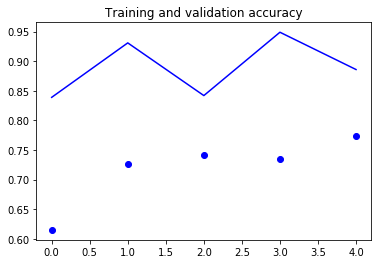

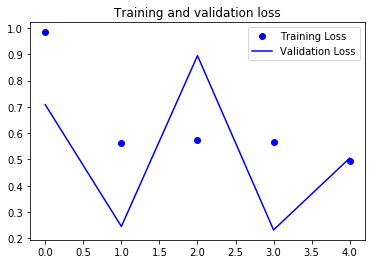

In [17]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
from keras.callbacks import CSVLogger
from livelossplot.keras import PlotLossesCallback

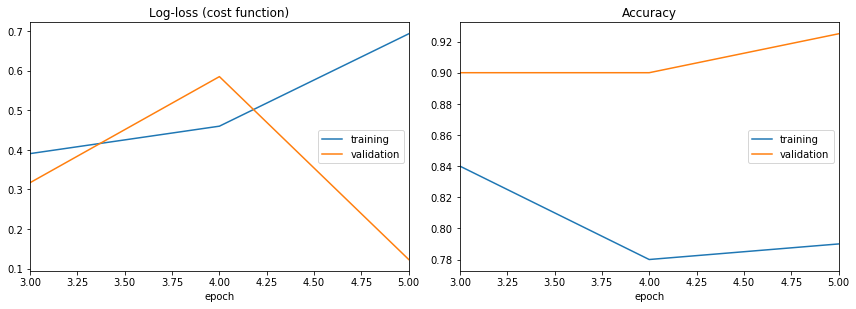

Log-loss (cost function):
training   (min:    0.390, max:    0.693, cur:    0.693)
validation (min:    0.001, max:    0.585, cur:    0.123)

Accuracy:
training   (min:    0.770, max:    0.840, cur:    0.790)
validation (min:    0.900, max:    1.000, cur:    0.925)


In [24]:
# Training
model.fit_generator(
    train_generator,
    steps_per_epoch=100 // 20,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=50 // 20,
    callbacks=[PlotLossesCallback(), CSVLogger('Cats_and_Dogs_inception',
                                            append=False,
                                            separator=";")], 
    verbose=1)
#model.save_weights(MODEL_FILE)

In [25]:
#An approach where we do not use all the layers in the pre-trained model

last_layer = pre_trained_model.get_layer('mixed7') #Only use layers including and above 'mixed7'
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [30]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

callbacks = myCallback()
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 50,
            epochs = 5,
            validation_steps = 50,
            verbose = 2,
            callbacks=[callbacks])

last layer output shape:  (None, 7, 7, 768)
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/5
 - 135s - loss: 0.5816 - acc: 0.7170 - val_loss: 0.1674 - val_acc: 0.9440
Epoch 2/5
 - 149s - loss: 0.4289 - acc: 0.8110 - val_loss: 0.4055 - val_acc: 0.9000
Epoch 3/5
 - 129s - loss: 0.3871 - acc: 0.8340 - val_loss: 0.2466 - val_acc: 0.9350
Epoch 4/5
 - 128s - loss: 0.3513 - acc: 0.8570 - val_loss: 0.2338 - val_acc: 0.9400
Epoch 5/5
 - 124s - loss: 0.3509 - acc: 0.8400 - val_loss: 0.5882 - val_acc: 0.8910


In [36]:
pip install google-colab

Processing c:\users\admin\appdata\local\pip\cache\wheels\38\0d\59\701e300a337b2a2e07b27fe74dbfff0bc56ac58f711566ee67\google_colab-1.0.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/18/c3/76775a650cae2e3d9c033b26153583e61282692d9a3af12a3022d8f0cefa/ipykernel-4.6.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/7d/e3/20f3d364d6c8e5d2353c72a67778eb189176f08e873c9900e10c0287b84b/requests-2.21.0-py2.py3-none-any.whl
Processing c:\users\admin\appdata\local\pip\cache\wheels\4a\45\47\1e126be9d4605e71f00d6e6fb151611f2f4cb9770b050c7d2d\portpicker-1.2.0-cp37-none-any.whl
  Using cached https://files.pythonhosted.org/packages/96/a2/d951ebb7855743f989287486ded73cd3f66915c3ecd9c5c5a0c7ca12377a/notebook-5.2.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/61/c7/f943fceb712579bc538700e2c157dc4972e16abfe29bd4969149bad98c74/pandas-0.24.2-cp37-cp37m-win_amd64.whl
  Found existing installation: ipykernel 5.1.3
    Uninsta

ERROR: rasa-sdk 1.3.2 requires flask-cors~=3.0, which is not installed.
ERROR: rasa-core 0.14.5 requires flask-cors~=3.0, which is not installed.
ERROR: rasa-core-sdk 0.14.0 requires flask-cors~=3.0, which is not installed.
ERROR: spyder-kernels 0.5.2 has requirement ipykernel>=4.8.2, but you'll have ipykernel 4.6.1 which is incompatible.
ERROR: rasa 1.3.3 has requirement jsonschema~=2.6, but you'll have jsonschema 3.1.1 which is incompatible.
ERROR: rasa 1.3.3 has requirement scikit-learn~=0.20.0, but you'll have scikit-learn 0.21.3 which is incompatible.
ERROR: rasa 1.3.3 has requirement scikit-learn~=0.20.2, but you'll have scikit-learn 0.21.3 which is incompatible.
ERROR: rasa-nlu 0.15.1 has requirement cloudpickle~=0.6.1, but you'll have cloudpickle 1.2.2 which is incompatible.
ERROR: rasa-nlu 0.15.1 has requirement jsonschema~=2.6, but you'll have jsonschema 3.1.1 which is incompatible.
ERROR: rasa-nlu 0.15.1 has requirement klein~=17.10, but you'll have klein 17.2.0 which is inc

In [ ]:
#Test with custom images

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")